In [1]:
%matplotlib inline
from __future__ import print_function
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.engine.topology import Layer
import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output
from helpers import plot_model_history
from keras.utils import plot_model
from IPython.display import Image as DImage


#K.set_image_data_format('channels_last')  # TF dimension ordering in this code

#img_rows = 256
#img_cols = 256
#n_class = 3

#smooth = 1.

Using TensorFlow backend.


## Loading and preprocessing data

In [2]:
print('-'*30)
print('Loading and preprocessing training and validation data...')
print('-'*30)

path = 'local_data/'

imgs_train = np.load(path+'parts_train.npy')
imgs_mask_train = np.load(path+'parts_train_labels.npy')

#imgs_train = preprocess(imgs_train)
#imgs_mask_train = preprocess(imgs_mask_train)

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
#imgs_mask_train /= 255.  # scale masks to [0, 1]


imgs_validation = np.load(path+'parts_validation.npy')
imgs_mask_validation = np.load(path+'parts_validation_labels.npy')

imgs_validation -= mean
imgs_validation /= std

imgs_mask_validation = imgs_mask_validation.astype('float32')
#imgs_mask_validation /= 255.  # scale masks to [0, 1]



------------------------------
Loading and preprocessing train data...
------------------------------


## Data augmentation

Horizontal flip

In [3]:
flip = np.flip(imgs_train, axis=2)
flip_mask = np.flip(imgs_mask_train, axis=2)

imgs_train = np.concatenate([imgs_train,flip])
imgs_mask_train = np.concatenate([imgs_mask_train,flip_mask])

(3000, 256, 256, 3)

In [5]:
def get_u_net(img_shape, n_class, depth, n_layers=8, filter_shape=(3,3), kernel_shape=(4,4)):
    img_rows = img_shape[0]
    img_cols = img_shape[1]
    inputs = Input((img_rows, img_cols, n_class))
    
    # array for first half of convolutional layers. 
    # They are stored so we can use them in the upsampling part.
    conv_layers = []

    input_h = inputs
    #conv = inputs
    for i in range(0, depth):
        n_layers *= 2
        conv = Conv2D(n_layers, filter_shape, activation='relu', padding='same')(input_h)
        conv = BatchNormalization()(conv)
        conv_layers.insert(0, conv)
        input_h = MaxPooling2D(pool_size=(2,2))(conv)

    n_layers *= 2
    conv = Conv2D(n_layers, filter_shape, activation='relu', padding='same')(input_h)

    
    for j in range(0, depth):
        n_layers = int(n_layers / 2)

        conv_trans = Conv2DTranspose(n_layers, kernel_shape, strides=(2, 2), padding='same')(conv)
        up = keras.layers.add([conv_trans, conv_layers[j]])
        conv = Conv2D(n_layers, filter_shape, activation='relu', padding='same')(up)
        #conv = BatchNormalization()(conv)

    conv = Conv2D(n_class, (1, 1), activation='softmax')(conv)

    model = Model(inputs=[inputs], outputs=[conv])
    model.compile(optimizer=Adam(lr=1e-5), loss="categorical_crossentropy", metrics=['accuracy'])

    return model

model = get_u_net((256,256),3,8)


plot_model(model, to_file='images/u_net.png')


history = model.fit(imgs_train, 
                    imgs_mask_train, 
                    #validation_split=0.2,
                    validation_data=(imgs_validation, imgs_mask_validation),
                    batch_size=16, 
                    epochs=20, 
                    verbose=1, 
                    shuffle=True)

Train on 3000 samples, validate on 500 samples
Epoch 1/20
3000/3000 [==============================] - 216s - loss: 1.0448 - acc: 0.5685 - val_loss: 0.9049 - val_acc: 0.6327
Epoch 2/20
3000/3000 [==============================] - 196s - loss: 0.5527 - acc: 0.7932 - val_loss: 0.5286 - val_acc: 0.8140
Epoch 3/20
3000/3000 [==============================] - 195s - loss: 0.3718 - acc: 0.8564 - val_loss: 0.3360 - val_acc: 0.8711
Epoch 4/20
3000/3000 [==============================] - 195s - loss: 0.2824 - acc: 0.8931 - val_loss: 0.2797 - val_acc: 0.8973
Epoch 5/20
3000/3000 [==============================] - 195s - loss: 0.2381 - acc: 0.9102 - val_loss: 0.2574 - val_acc: 0.9057
Epoch 6/20
3000/3000 [==============================] - 195s - loss: 0.2098 - acc: 0.9207 - val_loss: 0.2485 - val_acc: 0.9099
Epoch 7/20
3000/3000 [==============================] - 195s - loss: 0.1881 - acc: 0.9284 - val_loss: 0.2387 - val_acc: 0.9126
Epoch 8/20
3000/3000 [==============================] - 195s - l

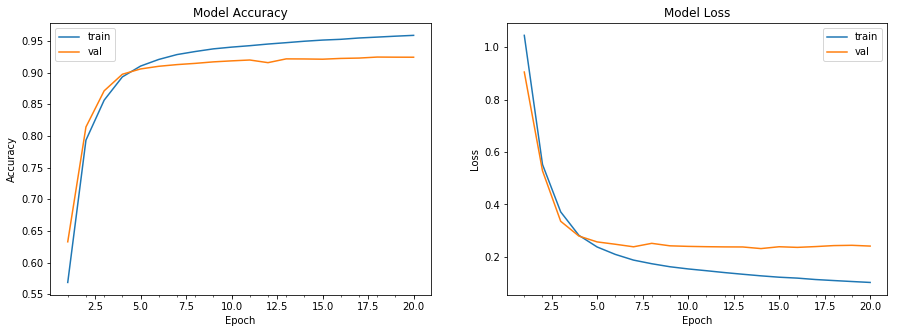

In [7]:
from helpers import plot_model_history

plot_model_history(history)

In [ ]:
model.save('trained_models/u_net.h5')